<a href="https://colab.research.google.com/github/ivkarla/connectivity_change/blob/main/notebooks/connectivity_measure_ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook creates the Figure 4 heatmap, showing the average overlap of single-measure networks with the most accurate multi-measure networks. This approach tries to rank the connectivity measures to assign importance of each one in identifying the epileptogenic network.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

from google.colab import drive
drive.mount('/content/gdrive')
main_folder = "/content/gdrive/Shared drives/A&K/data/"

Mounted at /content/gdrive


First, we define a function for managing labels of connectivity measures, for readibility.

In [4]:
import re

# Dictionary for band symbol substitutions
band_subs = {
    "1,4": "δ",
    "4,8": "ϴ",
    "8,12": "α",
    "13,30": "β",
    "30,70": "low γ",
    "70,150": "high γ"
}

# Dictionary for connectivity method substitutions
cm_subs = {
    "SC_R": "Real spectral coherence",
    "SC_I": "Imaginary spectral coherence",
    "PLV": "Phase-locking value",
    "PLI": "Phase lag index",
    "CC": "Cross-correlation",
    "PAC": "PAC",
    "PEC": "PEC"
}

# Function to replace bands with their corresponding symbols
def substitute_bands(s):
    # Find all occurrences of band ranges in the format "(a,b)"
    bands = re.findall(r'\(\d+,\d+\)', s)

    # Substitute each band range with its corresponding symbol
    for band in bands:
        band_range = band[1:-1]  # Remove parentheses
        if band_range in band_subs:
            s = s.replace(band, f" ({band_subs[band_range]})")

    return s

# Function to replace connectivity methods with their corresponding names
def substitute_cm(s):
    # Find all occurrences of connectivity method prefixes
    for cm in cm_subs:
        s = re.sub(r'\b' + cm + r'\b', cm_subs[cm], s)

    return s

# Test
input_str = "CC(30,70), SC_R(70,150)"
output_str = substitute_cm(input_str)
output_str = substitute_bands(output_str)

print("Input:", input_str)
print("Output:", output_str)

Input: CC(30,70), SC_R(70,150)
Output: Cross-correlation (low γ), Real spectral coherence (high γ)


In [8]:
markers = []

frames = ["NN", "N60S", "NS", "NE"]

n_opt = {"NN":4, "N60S":5, "NS":4, "NE":3}

submeta = pd.read_excel(main_folder + 'subsmeta.xlsx')
subjects = list(submeta["sub"])

methods = ['PAC', 'PEC', 'SC_R(1,4)', 'SC_I(1,4)', 'PLV(1,4)', 'PLI(1,4)', 'CC(1,4)', 'SC_R(4,8)', 'SC_I(4,8)', 'PLV(4,8)', 'PLI(4,8)', 'CC(4,8)', 'SC_R(8,12)', 'SC_I(8,12)', 'PLV(8,12)', 'PLI(8,12)', 'CC(8,12)', 'SC_R(13,30)', 'SC_I(13,30)', 'PLV(13,30)', 'PLI(13,30)', 'CC(13,30)', 'SC_R(30,70)', 'SC_I(30,70)', 'PLV(30,70)', 'PLI(30,70)', 'CC(30,70)', 'SC_R(70,150)', 'SC_I(70,150)', 'PLV(70,150)', 'PLI(70,150)', 'CC(70,150)']


Compare networks found by single connectivity measures with the multi-measure networks that yielded the most accurate outcome prediction. Save the mean overlaps.

In [14]:
grouped_means = {x:[] for x in methods}

for frame in frames:

    sublvl_overlap = {x:[] for x in methods}
    n = n_opt[frame]
    print("Time frame:", frame, "\nCombination step: ", n)

    multi = pd.read_excel(main_folder + f'{n}cm_rocauc_results.xlsx')
    multi = multi[multi['WOI']==frame]

    b = list(multi["AUC"])[0]
    av_auc = np.mean(list(multi["AUC"]))
    avsd_auc = av_auc + np.std(list(multi["AUC"]))
    threshold = av_auc
    print("Average AUC =", threshold)

    if frame=="N60S": ext="ns"
    else: ext=frame.lower()

    for sub in subjects:

        end = {}
        net_path = main_folder + 'reality_check/{}/nodes/'.format(frame)
        file = '{}-{}.csv'.format(sub,ext)

        r = pd.read_csv(net_path+file, header=None)

        with open(net_path+file, 'r') as csvfile:
                datareader = csv.reader(csvfile)
                for row in datareader:
                    if row!=[]:
                        met = row[0]
                        en_csv = row[1].replace(" ","")[1:-1].split(",")
                        en = list(e[1:-1] for e in en_csv)
                        end[met]=en

        for tm in methods:
            if tm not in end: end[tm]=[]

        above_av = sorted(list(a for a in multi["AUC"].unique() if a >= threshold)) # Sorted from lowest to highest AUC
        gb = multi.groupby(["AUC"])

        av_ppt, sav_ppt = {}, {}

        for i,auc in enumerate(above_av):

            combs, collect = [],[]
            g = list(gb.get_group(auc)["CM"])

            # Reformat strings and save combinations to combs list
            for comb in g:
                comb_t = []
                for m_str in comb.split(", "):
                    comb_t.append(m_str)
                    collect.append(m_str)
                combs.append(tuple(comb_t))

            n_comb = len(combs)

            for t in combs:
                u_t = list(list(end[m]) for m in t)
                union = sorted(set([item for sublist in list(u_t) for item in sublist]))
                for M in end:
                    sublvl_overlap[M].append((len(list((set(end[M]) & set(union))))/len(union)))

    for mid in grouped_means:
        grouped_means[mid].append(np.mean(sublvl_overlap[mid]))

print(grouped_means)


Time frame: NN 
Combination step:  4
Average AUC = 0.6810373203786521
Time frame: N60S 
Combination step:  5
Average AUC = 0.6631622581877685
Time frame: NS 
Combination step:  4
Average AUC = 0.6968038466777146
Time frame: NE 
Combination step:  3
Average AUC = 0.7357184002633311
{'PAC': [0.14010663768859183, 0.12971831689909527, 0.17970643850516296, 0.36913575483471106], 'PEC': [0.13316557733049572, 0.11967081890637067, 0.19030957394326792, 0.5942937314049148], 'SC_R(1,4)': [0.1003642998387871, 0.11149516877561566, 0.10696849257877682, 0.47833372804999236], 'SC_I(1,4)': [0.12176483327558726, 0.12820554115939792, 0.10053072539744476, 0.47833372804999236], 'PLV(1,4)': [0.18057893753877094, 0.16922777746159717, 0.1678036192879032, 0.5942937314049148], 'PLI(1,4)': [0.07709444417954636, 0.11119074640776791, 0.09788030343951751, 0.5942937314049148], 'CC(1,4)': [0.09727721333845984, 0.11654915338389515, 0.1342919954732376, 0.21337134553101095], 'SC_R(4,8)': [0.10615541315038843, 0.112695283

To save time for visualization, the mean overlap is explicitly defined here.

In [6]:
grouped_means = {'PAC': [0.14010663768859183, 0.12971831689909527, 0.17970643850516296, 0.36913575483471106], 'PEC': [0.13316557733049572, 0.11967081890637067, 0.19030957394326792, 0.5942937314049148], 'SC_R(1,4)': [0.1003642998387871, 0.11149516877561566, 0.10696849257877682, 0.47833372804999236], 'SC_I(1,4)': [0.12176483327558726, 0.12820554115939792, 0.10053072539744476, 0.47833372804999236], 'PLV(1,4)': [0.18057893753877094, 0.16922777746159717, 0.1678036192879032, 0.5942937314049148], 'PLI(1,4)': [0.07709444417954636, 0.11119074640776791, 0.09788030343951751, 0.5942937314049148], 'CC(1,4)': [0.09727721333845984, 0.11654915338389515, 0.1342919954732376, 0.21337134553101095], 'SC_R(4,8)': [0.10615541315038843, 0.11269528373854865, 0.16253939338765314, 0.1940292072591772], 'SC_I(4,8)': [0.12235036049619023, 0.11563635047389273, 0.10011927953589546, 0.47833372804999236], 'PLV(4,8)': [0.09359939119320958, 0.10819349853956078, 0.1541718220555081, 0.3469963258361429], 'PLI(4,8)': [0.081460164098448, 0.08941272104381132, 0.09388581095785511, 0.5942937314049148], 'CC(4,8)': [0.11557166450877819, 0.11002070064567755, 0.14773323130026253, 0.21337134553101095], 'SC_R(8,12)': [0.10905972860306112, 0.0685492532984715, 0.1340085911864803, 0.19153386984303333], 'SC_I(8,12)': [0.09222164349837837, 0.10517898644356989, 0.10127672888305651, 0.47833372804999236], 'PLV(8,12)': [0.1036667304813098, 0.08710296760327502, 0.13862172172045065, 0.3469963258361429], 'PLI(8,12)': [0.08858899280168578, 0.10936904161983829, 0.09793975539543759, 0.5942937314049148], 'CC(8,12)': [0.13680540872800834, 0.12133428755206699, 0.14912544266018984, 0.21337134553101095], 'SC_R(13,30)': [0.07928273982713292, 0.09823175657400915, 0.07215830494401129, 0.19153386984303333], 'SC_I(13,30)': [0.09586101236081299, 0.10068079596078917, 0.08589486566148338, 0.47833372804999236], 'PLV(13,30)': [0.09203974911365556, 0.08366946504015295, 0.08660353102295494, 0.3469963258361429], 'PLI(13,30)': [0.06838406227543804, 0.10526169126242187, 0.08225669515582702, 0.5942937314049148], 'CC(13,30)': [0.11277637418049392, 0.15547380076788878, 0.19802046294809444, 0.24425324651478628], 'SC_R(30,70)': [0.08518382589971987, 0.1045062756068729, 0.10710205842326058, 0.19153386984303333], 'SC_I(30,70)': [0.08450352983039033, 0.09870826026770904, 0.08881387972676054, 0.47833372804999236], 'PLV(30,70)': [0.08582842679066571, 0.14167391915242153, 0.1271244147518299, 0.17327039814595274], 'PLI(30,70)': [0.07208385498413634, 0.09228504200637656, 0.08221541112375982, 0.5942937314049148], 'CC(30,70)': [0.139719440480005, 0.11942475573252471, 0.16664187748632586, 0.47833372804999236], 'SC_R(70,150)': [0.10679382223392683, 0.09298714355613467, 0.08377743081677916, 0.19153386984303333], 'SC_I(70,150)': [0.0884632962751819, 0.10902027588005023, 0.09354395454598105, 0.47833372804999236], 'PLV(70,150)': [0.08840396686606683, 0.14469838127278536, 0.12194262745415843, 0.21337134553101095], 'PLI(70,150)': [0.0986194571605218, 0.10326285233117444, 0.1017628231998401, 0.5942937314049148], 'CC(70,150)': [0.10602232526879922, 0.1061688188527394, 0.1526976804803108, 0.47833372804999236]}


Sort the results dictionary for readibility.

Plot heatmap.

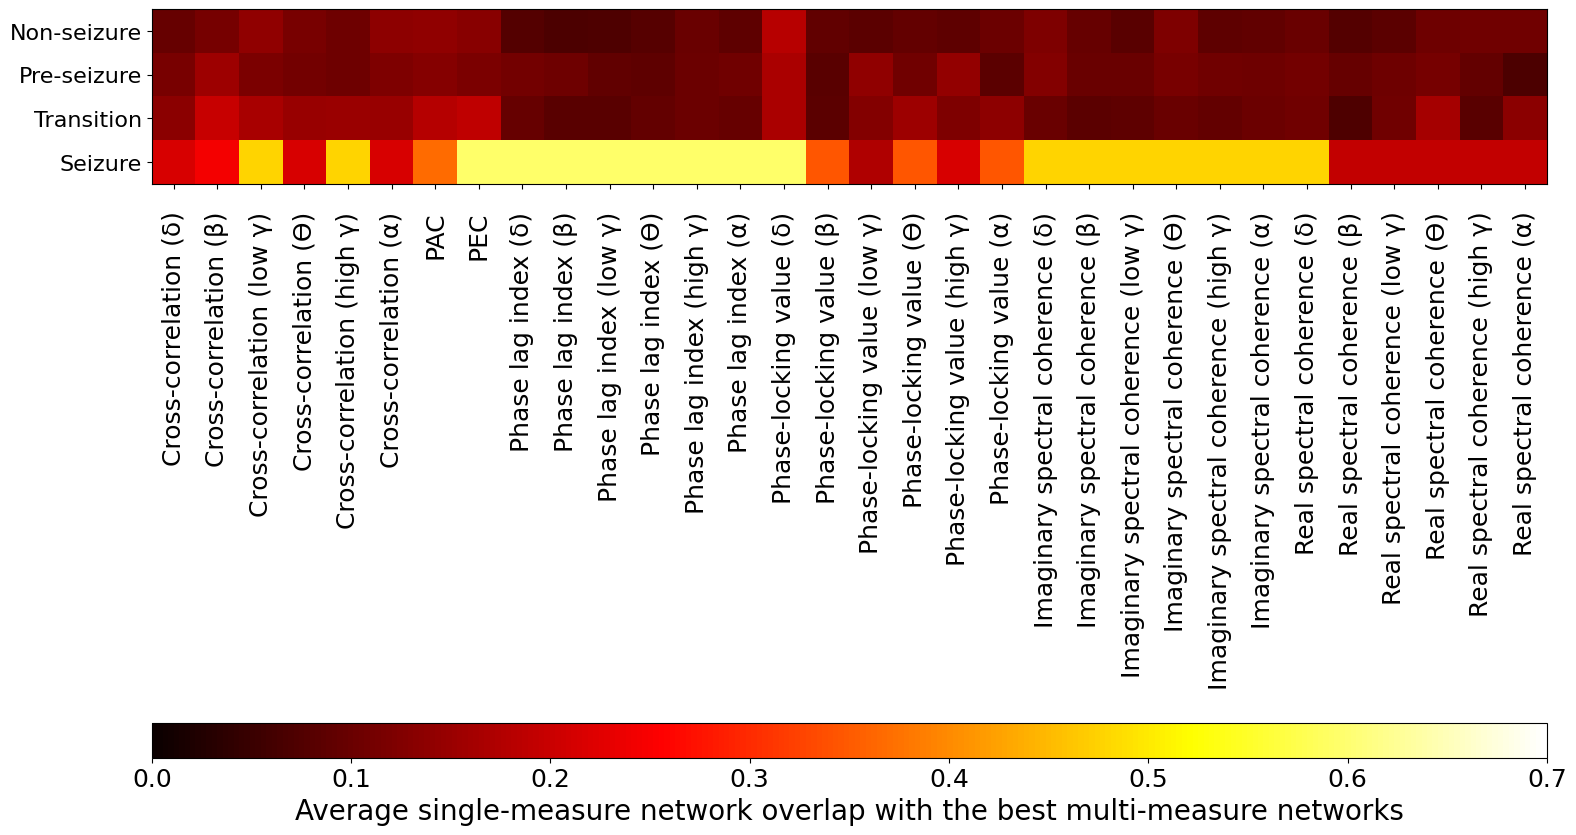

In [47]:
sorted_grouped_means = {key: grouped_means[key] for key in sorted(grouped_means)}

a = np.vstack(tuple(list(sorted_grouped_means.values()))).T

method_order = [substitute_bands(substitute_cm(cm_label)) for cm_label in list(sorted_grouped_means.keys())]

fig = plt.figure(figsize=(18, 20))
ax = fig.add_subplot()

# Setting y-axis ticks and labels
ax.set_yticks(list(range(4)))
ax.set_yticklabels(['Non-seizure', 'Pre-seizure', 'Transition', 'Seizure'], size=16)

# Setting x-axis ticks and labels
ax.set_xticks(list(range(32)))
ax.set_xticklabels(method_order, rotation=90, size=18)

# Move x-axis labels downwards
for tick in ax.get_xticklabels():
    tick.set_verticalalignment('top')
    tick.set_position((tick.get_position()[0], -0.1))  # Adjust the second value to move labels down

plt.grid(False)
hm = plt.imshow(a, cmap='hot', interpolation='nearest')
cb = plt.colorbar(hm, orientation="horizontal", pad=0.35, aspect=40)
cb.ax.tick_params(labelsize=18)
cb.set_label('Average single-measure network overlap with the best multi-measure networks', size=20)
plt.clim(0.0, 0.7)
plt.savefig(main_folder + 'Fig4_heatmap.png', bbox_inches='tight')
plt.show()